# Лабораторна робота 5
## Глибокі генеративні моделі
### Щербакова Валерія, ФІ-71
Part 2 dataset: CIFAR-100

**Перша частина в файлі [Laba5-1.ipynb]().**

# 2. Генерація зображень
Вирішіть завдання генерації зображень (архітектура за вашим вибором: **GAN**/DCGAN/VAE/CVAE), якщо в обраному датасеті багато класів, залиште декілька

In [86]:
import numpy as np, matplotlib.pyplot as plt, time, datetime
from keras.layers import Dense, Reshape, Flatten, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import  Conv2D, Conv2DTranspose
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar100

In [66]:
(x_train, y_train), (_, _) = cifar100.load_data()

In [69]:
print(x_train.shape)
print(x_train[0][16][16])

(50000, 32, 32, 3)
[122  70  79]


In [70]:
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # normalization [-1, 1]
x_train = np.clip(x_train, -1, 1)
print(x_train[0][16][16])

[-0.04313726 -0.4509804  -0.38039216]


Приклад вхідних даних

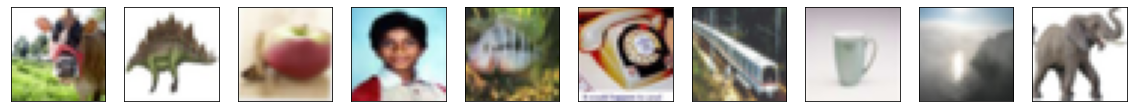

In [157]:
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow((x_train[i] + 1) / 2)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [72]:
optim = Adam(learning_rate=0.0002, beta_1=0.5)
latent_dim = 100

Побудова моделі генератора

In [74]:
def build_generator():
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

Побудова моделі дискримінатора

In [ ]:
def build_discriminator():
    model = Sequential()
    # normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape=(32,32,3)))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
    return model

Комбінована GAN модель з генератора та дискримінатора

In [76]:
def build_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

Тренування GAN моделі (почергове тренування генератора та дискримінатора)

In [94]:
discrim_losses = []

def train_model(epochs, batch_size, models, start_ep=0):
    start = curr = time.time()
    generator, discriminator, gan = models
    num_batches = int(x_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake CIFAR images
            generated_images = generator.predict(noise)

            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9  # (instead of 1.0) sort of trick in GAN training, so called label smoothing
            # Train discriminator
            discriminator.trainable = True
            d_loss, _ = discriminator.train_on_batch(X, y_dis)
            discrim_losses.append(d_loss)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        ela = time.time() - curr
        curr = time.time()
        total = curr - start
        print('epoch: ' + str(start_ep+ep) + ', elapsed: ' + str(datetime.timedelta(seconds=ela)) + ', total: ' + str(datetime.timedelta(seconds=total)))
        if ep % 10 == 0:
            plot_generated_images(ep, generator)

Виведення результата роботи генератора на основі випадкового зображення в якості латентного входу

In [77]:
def plot_generated_images(epoch, generator):
    num_of_images = 10
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise)
    # scale from [-1,1] to [0,1]
    generated_images = (generated_images + 1) / 2.0

    plt.figure(figsize=(20, 4))
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [80]:
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

In [81]:
generator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_4 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

In [82]:
discriminator.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_29 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_31 (Conv2D)          (None, 4, 4, 256)        

Виконання тренування моделі (перші 50 ітерацій)

epoch: 0, elapsed: 0:00:27.516021, total: 0:00:27.516021


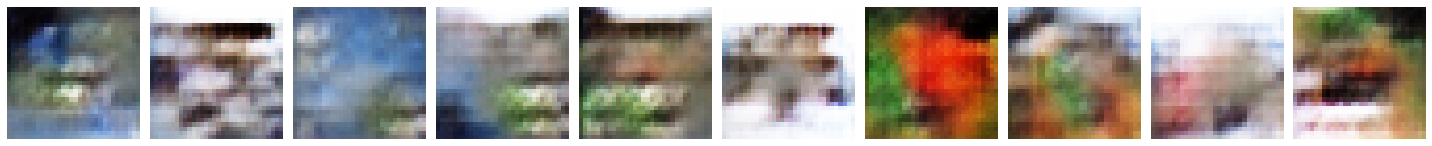

epoch: 1, elapsed: 0:00:28.785172, total: 0:00:56.301193
epoch: 2, elapsed: 0:00:28.474834, total: 0:01:24.776027
epoch: 3, elapsed: 0:00:28.508330, total: 0:01:53.284357
epoch: 4, elapsed: 0:00:29.452779, total: 0:02:22.737136
epoch: 5, elapsed: 0:00:28.407831, total: 0:02:51.144967
epoch: 6, elapsed: 0:00:29.583644, total: 0:03:20.728611
epoch: 7, elapsed: 0:00:29.336394, total: 0:03:50.065005
epoch: 8, elapsed: 0:00:28.794185, total: 0:04:18.859190
epoch: 9, elapsed: 0:00:28.690092, total: 0:04:47.549283
epoch: 10, elapsed: 0:00:28.355786, total: 0:05:15.905068


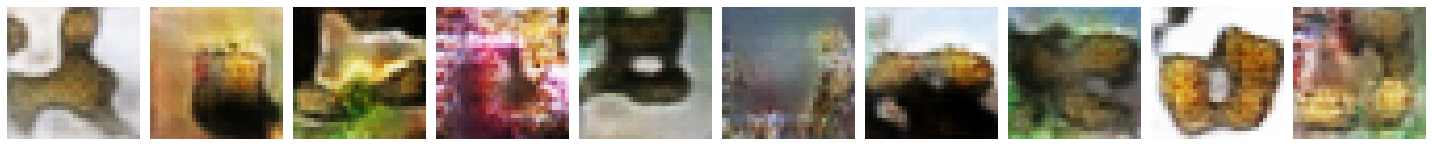

epoch: 11, elapsed: 0:00:28.867249, total: 0:05:44.772317
epoch: 12, elapsed: 0:00:27.474981, total: 0:06:12.247298
epoch: 13, elapsed: 0:00:28.229671, total: 0:06:40.476970
epoch: 14, elapsed: 0:00:28.504456, total: 0:07:08.981426
epoch: 15, elapsed: 0:00:28.208721, total: 0:07:37.190147
epoch: 16, elapsed: 0:00:28.145506, total: 0:08:05.335653
epoch: 17, elapsed: 0:00:28.733126, total: 0:08:34.068779
epoch: 18, elapsed: 0:00:27.288815, total: 0:09:01.357595
epoch: 19, elapsed: 0:00:28.257695, total: 0:09:29.615290
epoch: 20, elapsed: 0:00:27.277804, total: 0:09:56.893094


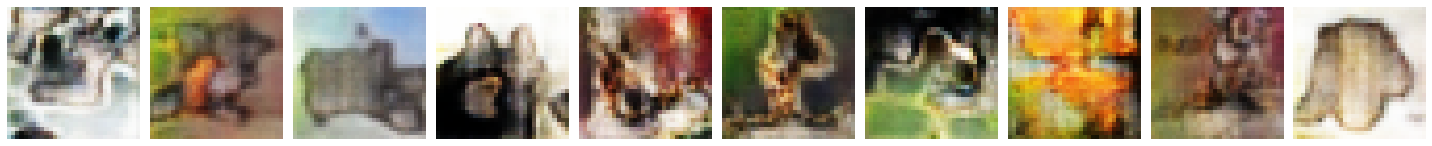

epoch: 21, elapsed: 0:00:28.284794, total: 0:10:25.177887
epoch: 22, elapsed: 0:00:27.383900, total: 0:10:52.561788
epoch: 23, elapsed: 0:00:27.615112, total: 0:11:20.176900
epoch: 24, elapsed: 0:00:26.940495, total: 0:11:47.117395
epoch: 25, elapsed: 0:00:27.401916, total: 0:12:14.519311
epoch: 26, elapsed: 0:00:27.390907, total: 0:12:41.910218
epoch: 27, elapsed: 0:00:26.978531, total: 0:13:08.888749
epoch: 28, elapsed: 0:00:27.498004, total: 0:13:36.386753
epoch: 29, elapsed: 0:00:26.907467, total: 0:14:03.294221
epoch: 30, elapsed: 0:00:27.374892, total: 0:14:30.669112


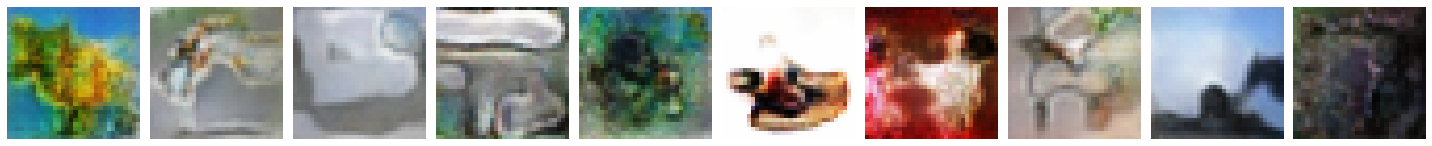

epoch: 31, elapsed: 0:00:27.842319, total: 0:14:58.511431
epoch: 32, elapsed: 0:00:29.242307, total: 0:15:27.753738
epoch: 33, elapsed: 0:00:28.221662, total: 0:15:55.975400
epoch: 34, elapsed: 0:00:29.062777, total: 0:16:25.038177
epoch: 35, elapsed: 0:00:30.375034, total: 0:16:55.413211
epoch: 36, elapsed: 0:00:29.400718, total: 0:17:24.813929
epoch: 37, elapsed: 0:00:29.619293, total: 0:17:54.433223
epoch: 38, elapsed: 0:00:28.085539, total: 0:18:22.518761
epoch: 39, elapsed: 0:00:28.473142, total: 0:18:50.991903
epoch: 40, elapsed: 0:00:28.792180, total: 0:19:19.784083


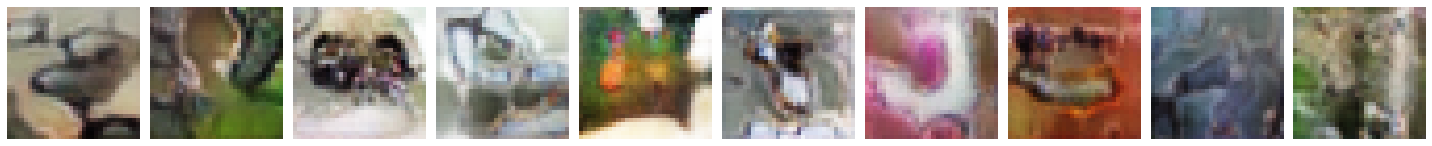

epoch: 41, elapsed: 0:00:28.946327, total: 0:19:48.730410
epoch: 42, elapsed: 0:00:29.304569, total: 0:20:18.034979
epoch: 43, elapsed: 0:00:28.257697, total: 0:20:46.292676
epoch: 44, elapsed: 0:00:28.453863, total: 0:21:14.746539
epoch: 45, elapsed: 0:00:27.443770, total: 0:21:42.190309
epoch: 46, elapsed: 0:00:27.768250, total: 0:22:09.958559
epoch: 47, elapsed: 0:00:27.170707, total: 0:22:37.129265
epoch: 48, elapsed: 0:00:27.671160, total: 0:23:04.800426
epoch: 49, elapsed: 0:00:27.655147, total: 0:23:32.455573
epoch: 50, elapsed: 0:00:27.092638, total: 0:23:59.548211


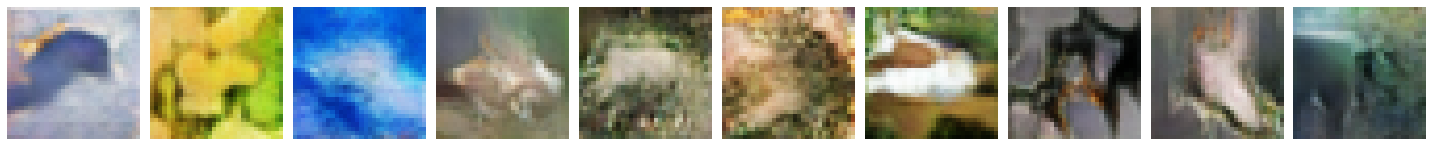

In [92]:
epochs = 50 # to get good quality images, you should train the model for more than 100 epochs
batch_size = 256
train_model(epochs, batch_size, (generator, discriminator, gan))

Продовження тренування моделі (наступні 50 ітерацій)

epoch: 50, elapsed: 0:00:27.195728, total: 0:00:27.195728


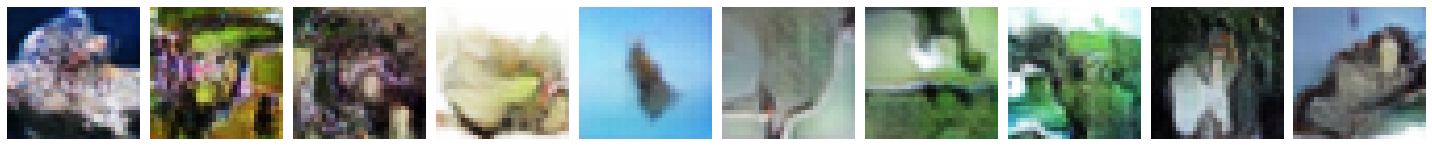

epoch: 51, elapsed: 0:00:27.657151, total: 0:00:54.852878
epoch: 52, elapsed: 0:00:27.323843, total: 0:01:22.176721
epoch: 53, elapsed: 0:00:27.370889, total: 0:01:49.547610
epoch: 54, elapsed: 0:00:27.436949, total: 0:02:16.984559
epoch: 55, elapsed: 0:00:27.180715, total: 0:02:44.165274
epoch: 56, elapsed: 0:00:27.189725, total: 0:03:11.354999
epoch: 57, elapsed: 0:00:27.370888, total: 0:03:38.725888
epoch: 58, elapsed: 0:00:31.583719, total: 0:04:10.309607
epoch: 59, elapsed: 0:00:27.292816, total: 0:04:37.602422
epoch: 60, elapsed: 0:00:27.299826, total: 0:05:04.902248


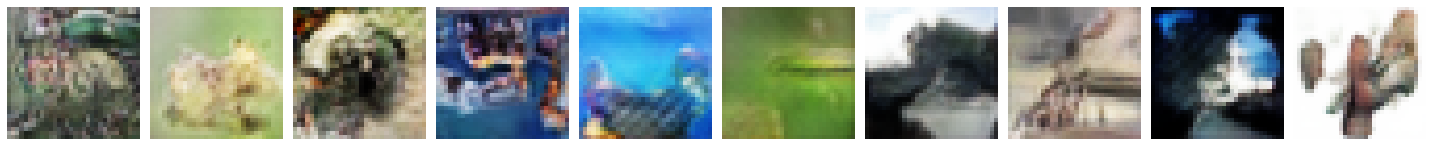

epoch: 61, elapsed: 0:00:29.122480, total: 0:05:34.024729
epoch: 62, elapsed: 0:00:27.361893, total: 0:06:01.386621
epoch: 63, elapsed: 0:00:27.719205, total: 0:06:29.105826
epoch: 64, elapsed: 0:00:27.298823, total: 0:06:56.404649
epoch: 65, elapsed: 0:00:29.022390, total: 0:07:25.427038
epoch: 66, elapsed: 0:00:27.922390, total: 0:07:53.349428
epoch: 67, elapsed: 0:00:27.467977, total: 0:08:20.817405
epoch: 68, elapsed: 0:00:28.221662, total: 0:08:49.039067
epoch: 69, elapsed: 0:00:27.420933, total: 0:09:16.460001
epoch: 70, elapsed: 0:00:27.615110, total: 0:09:44.075111


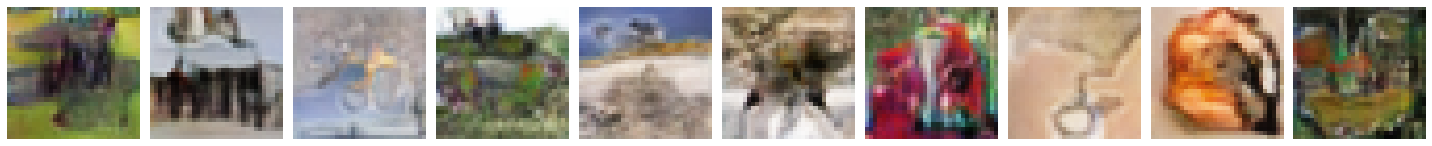

epoch: 71, elapsed: 0:00:28.169614, total: 0:10:12.244725
epoch: 72, elapsed: 0:00:28.543955, total: 0:10:40.788681
epoch: 73, elapsed: 0:00:27.654146, total: 0:11:08.442827
epoch: 74, elapsed: 0:00:27.389906, total: 0:11:35.832733
epoch: 75, elapsed: 0:00:28.517931, total: 0:12:04.350664
epoch: 76, elapsed: 0:00:27.593089, total: 0:12:31.943752
epoch: 77, elapsed: 0:00:27.385903, total: 0:12:59.329656
epoch: 78, elapsed: 0:00:28.060516, total: 0:13:27.390172
epoch: 79, elapsed: 0:00:27.388905, total: 0:13:54.779076
epoch: 80, elapsed: 0:00:27.268795, total: 0:14:22.047872


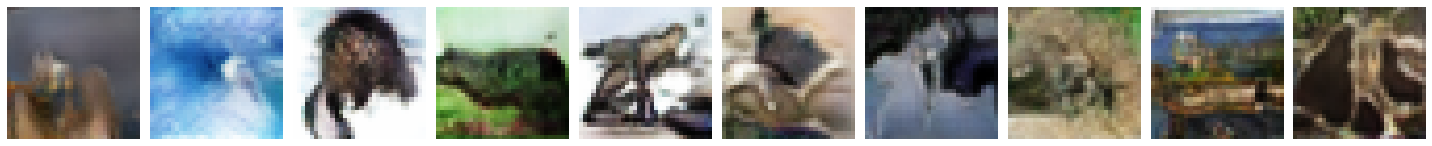

epoch: 81, elapsed: 0:00:27.929405, total: 0:14:49.977277
epoch: 82, elapsed: 0:00:27.433946, total: 0:15:17.411223
epoch: 83, elapsed: 0:00:28.081535, total: 0:15:45.492758
epoch: 84, elapsed: 0:00:27.996455, total: 0:16:13.489213
epoch: 85, elapsed: 0:00:27.475984, total: 0:16:40.965197
epoch: 86, elapsed: 0:00:28.136584, total: 0:17:09.101781
epoch: 87, elapsed: 0:00:27.464977, total: 0:17:36.566758
epoch: 88, elapsed: 0:00:27.533033, total: 0:18:04.099791
epoch: 89, elapsed: 0:00:27.654148, total: 0:18:31.753939
epoch: 90, elapsed: 0:00:27.179712, total: 0:18:58.933651


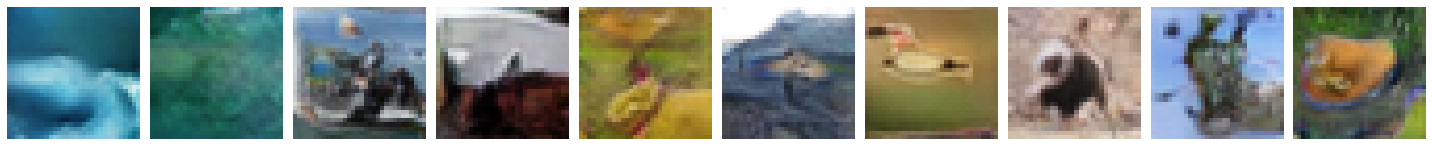

epoch: 91, elapsed: 0:00:28.193639, total: 0:19:27.127290
epoch: 92, elapsed: 0:00:27.062605, total: 0:19:54.189895
epoch: 93, elapsed: 0:00:27.207742, total: 0:20:21.397637
epoch: 94, elapsed: 0:00:27.769250, total: 0:20:49.166888
epoch: 95, elapsed: 0:00:26.975527, total: 0:21:16.142415
epoch: 96, elapsed: 0:00:26.983536, total: 0:21:43.125951
epoch: 97, elapsed: 0:00:27.507012, total: 0:22:10.632963
epoch: 98, elapsed: 0:00:27.449964, total: 0:22:38.082927
epoch: 99, elapsed: 0:00:27.372886, total: 0:23:05.455813
epoch: 100, elapsed: 0:00:28.477897, total: 0:23:33.933710


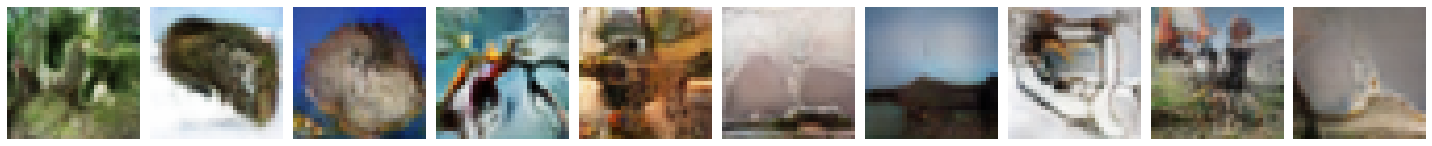

In [95]:
# continue training
train_model(epochs, batch_size, (generator, discriminator, gan), 50)

Виведення графіку похибок дискримінатора

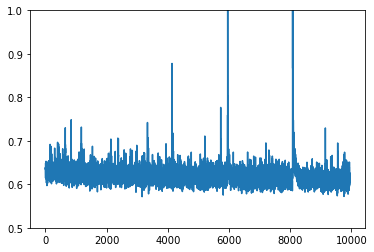

In [103]:
plt.plot(discrim_losses)
plt.gca().set_ylim([0.5, 1]);

Приклади згенерованих зображень на основі випадкових вхідних даних

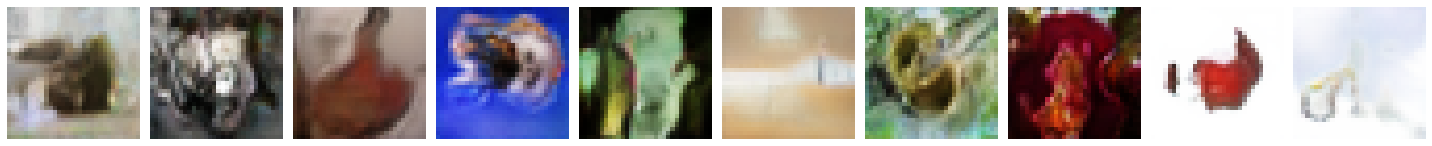

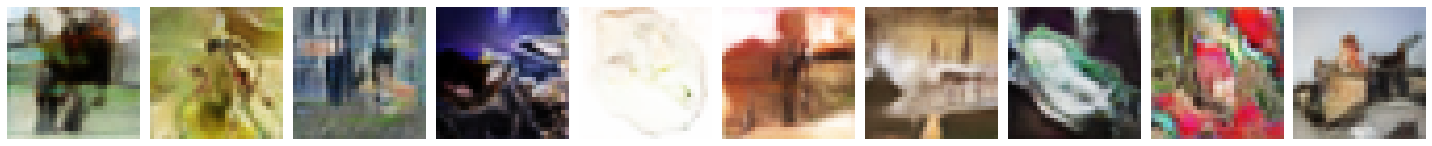

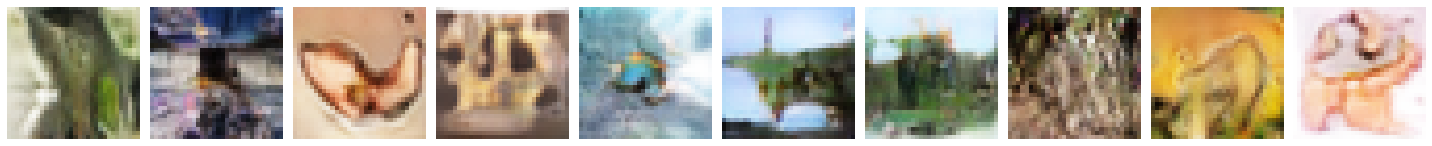

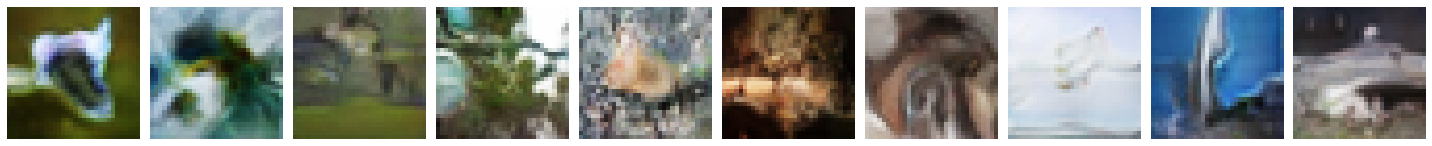

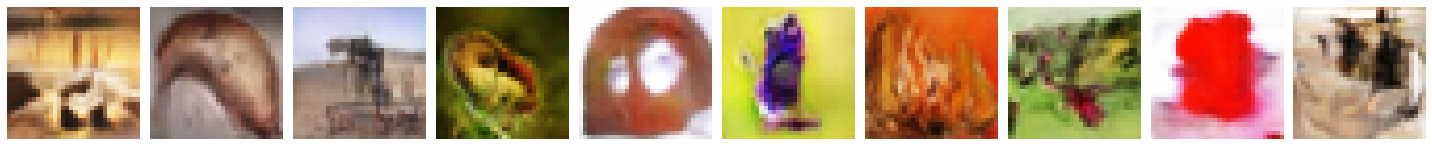

In [107]:
plot_generated_images(0, generator)
plot_generated_images(0, generator)
plot_generated_images(0, generator)
plot_generated_images(0, generator)
plot_generated_images(0, generator)

Зберегла моделі для подальших досліждень )

In [109]:
discriminator.save('discriminator.h5')
generator.save('generator.h5')
gan.save('gan.h5')

Тренування зайняло близько 50 хвилин, а результуючі зображення... можна сказати, досить цікаві.

Цікаво подивитись як будуть виглядати зображення при використанні певних невипадкових вхідних даних.

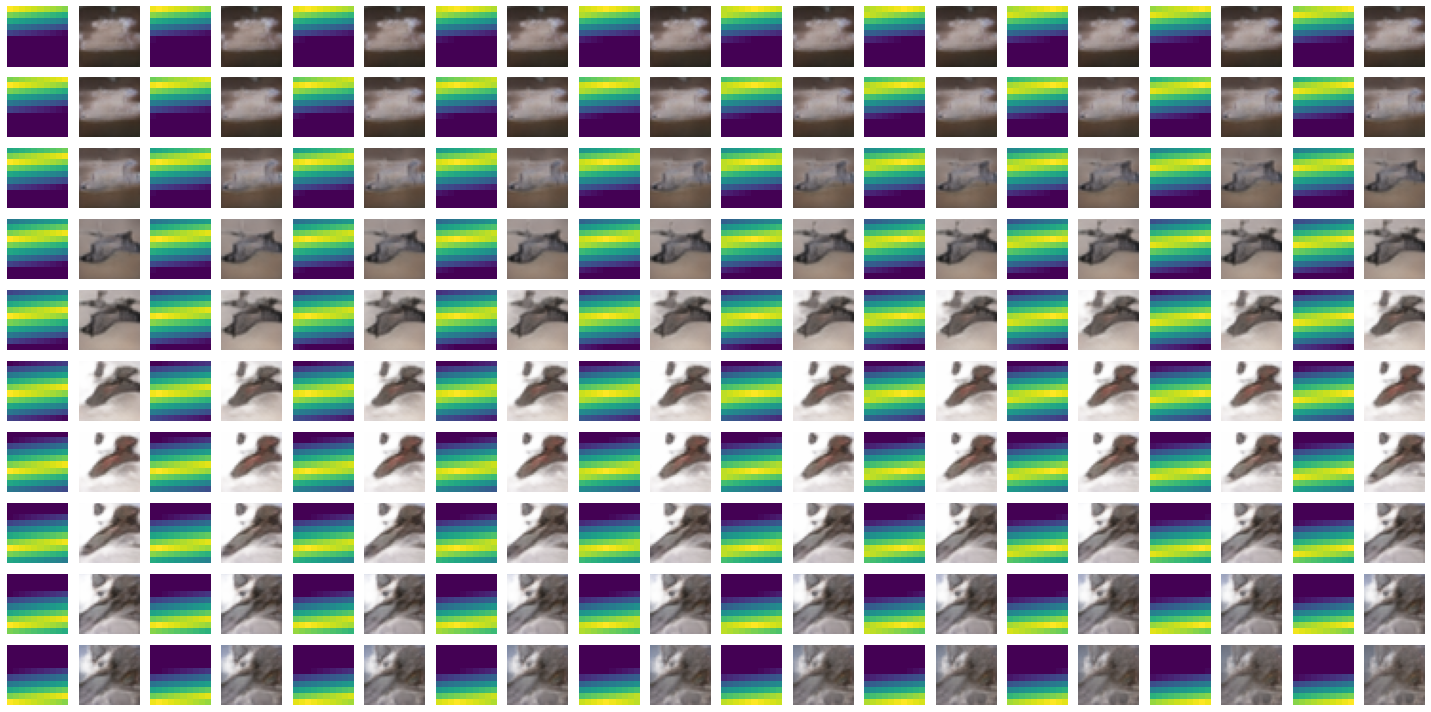

In [169]:
plt.figure(figsize=(20, 10))

for i in range(0, 100):
    latent = np.array([min(1, max(1 - abs(x - i) / 50, 0)) for x in range(0, 100)]).reshape([1, 100])
    generated = (generator.predict(latent) + 1) / 2.0

    plt.subplot(10, 20, 2*i+1)
    plt.imshow(np.reshape(latent[0], [10, 10]))
    plt.axis('off')

    plt.subplot(10, 20, 2*i+2)
    plt.imshow(generated[0])
    plt.axis('off')

plt.tight_layout()
plt.show()

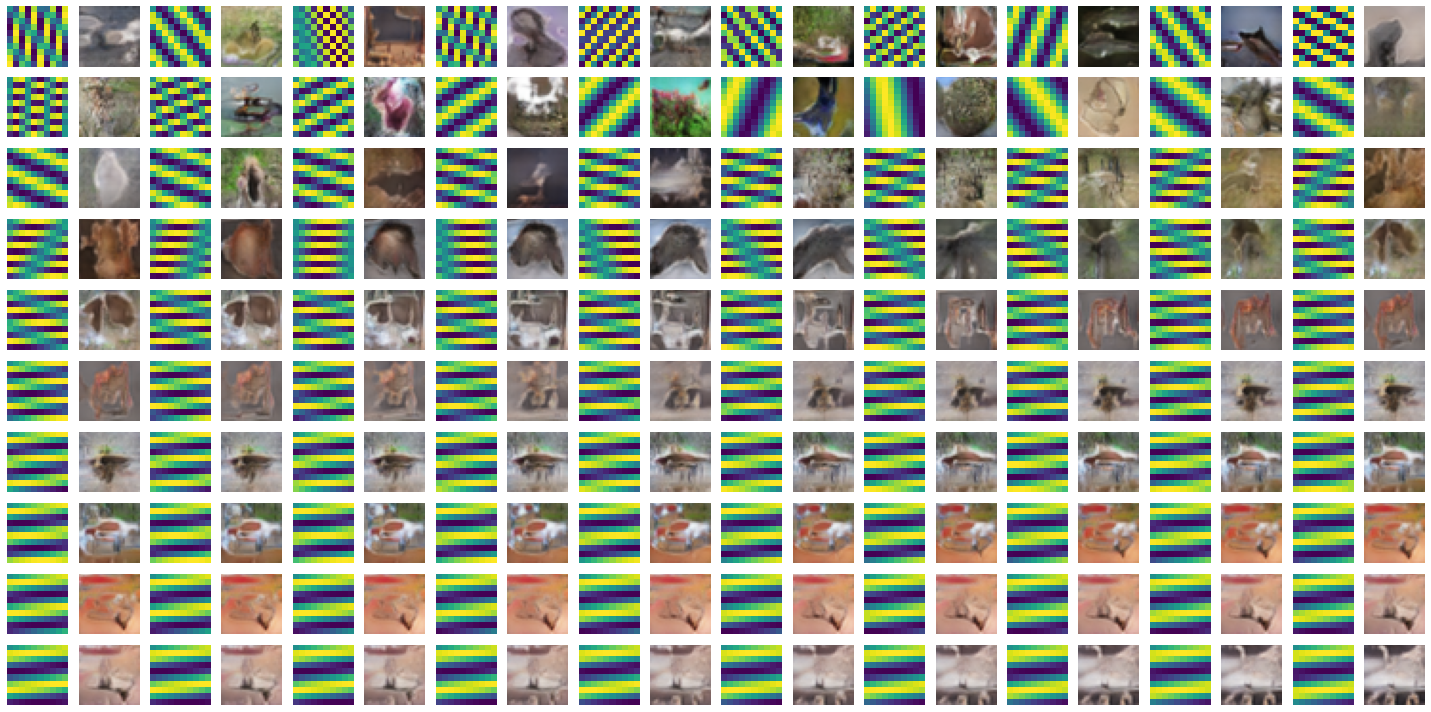

In [175]:
plt.figure(figsize=(20, 10))

for i in range(0, 100):
    latent = np.array([np.sin(10 * x / (i*0.95+1)) for x in range(0, 100)]).reshape([1, 100])
    generated = (generator.predict(latent) + 1) / 2.0

    plt.subplot(10, 20, 2*i+1)
    plt.imshow(np.reshape(latent[0], [10, 10]))
    plt.axis('off')

    plt.subplot(10, 20, 2*i+2)
    plt.imshow(generated[0])
    plt.axis('off')

plt.tight_layout()
plt.show()

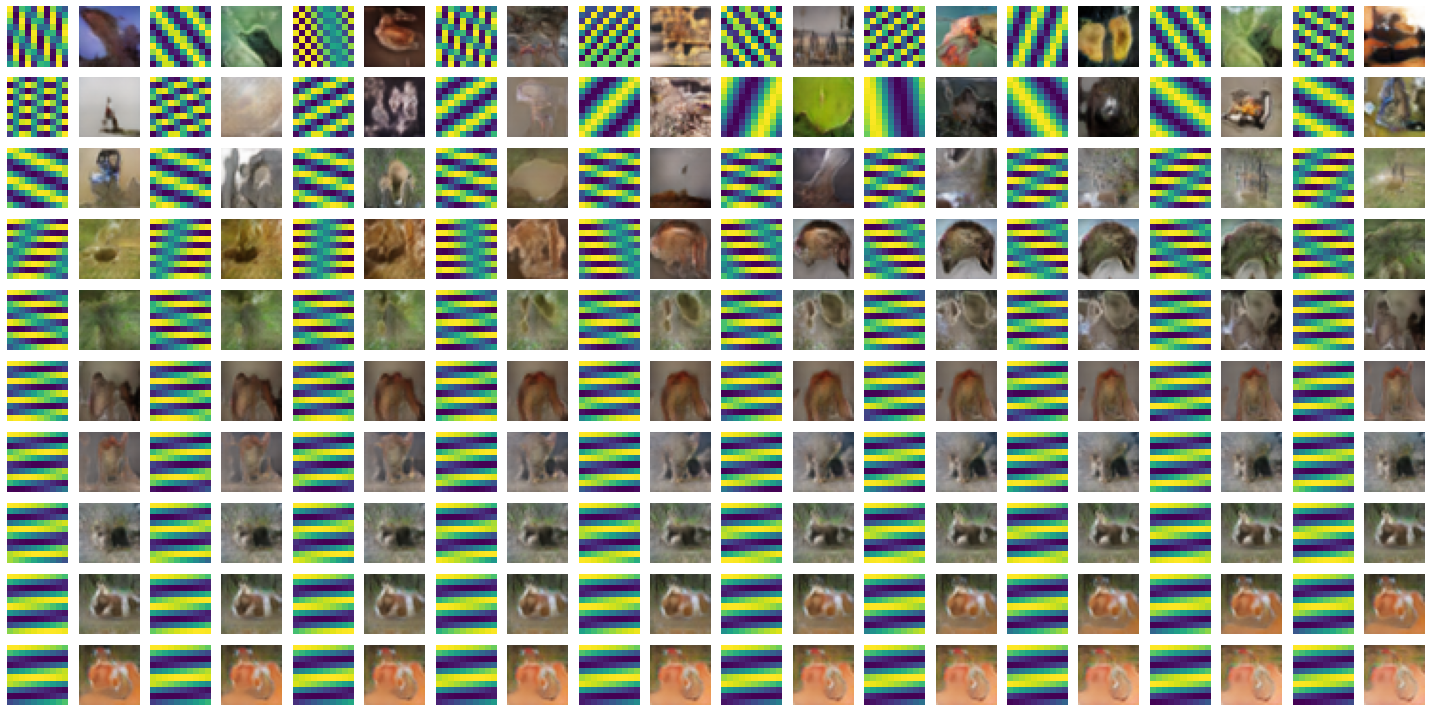

In [176]:
plt.figure(figsize=(20, 10))

for i in range(0, 100):
    latent = np.array([np.cos(10 * x / (i*0.95+1)) for x in range(0, 100)]).reshape([1, 100])
    generated = (generator.predict(latent) + 1) / 2.0

    plt.subplot(10, 20, 2*i+1)
    plt.imshow(np.reshape(latent[0], [10, 10]))
    plt.axis('off')

    plt.subplot(10, 20, 2*i+2)
    plt.imshow(generated[0])
    plt.axis('off')

plt.tight_layout()
plt.show()

Я вважаю, що вийшло досить цікаво)

На деяких зображеннях навіть щось схоже на реальне, наприклад третє в останньому сеті схоже на качечку)